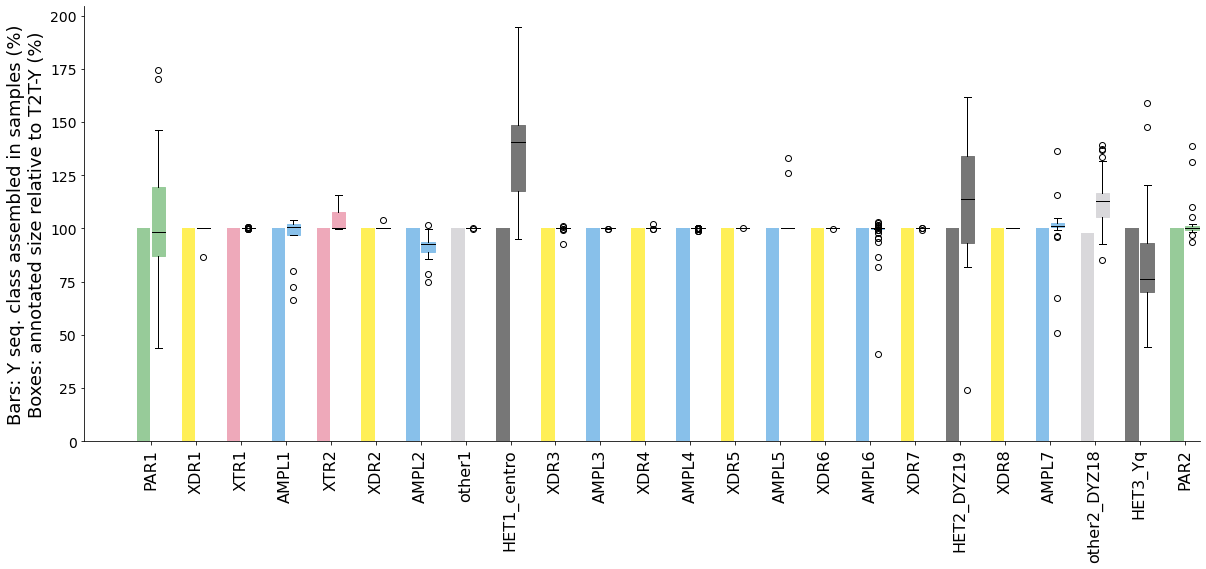

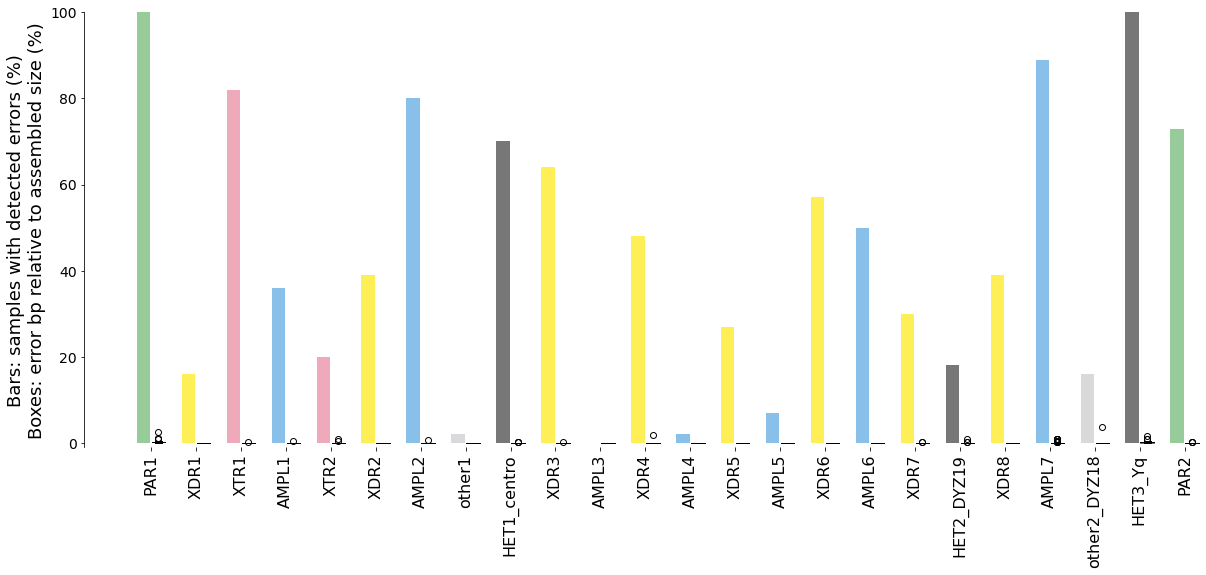

In [41]:
import pathlib as pl

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

"""
Uses output files of the pipeline rules:

prep_t2t_seq_class_cache_file
merge_agg_seqclass_errors

"""

wd = pl.Path('/home/local/work/data/sig_chrY/paper/errclust')

t2t_classes_file = wd / pl.Path('T2T.chrY-seq-classes.tsv')
t2t = pd.read_csv(t2t_classes_file, sep='\t', header=0)
t2t['region_size'] = t2t['end'] - t2t['start']

sample_classes_file = wd / pl.Path('SAMPLES.HIFIRW.ONTUL.na.chrY.mrg-seqclass-errors.tsv')
samples = pd.read_csv(sample_classes_file, sep='\t', header=0)

drop = ['NA24385', 'HG02666', 'NA19384', 'HG01457', 'NA18989']

samples = samples.loc[~samples['sample'].isin(drop), :].copy()

def plot_region_size_stats(t2t, samples, out_prefix=None):

    bars = []
    xpos_bars = []
    boxes = []
    xpos_boxes = []
    xpos = []

    xlabels = []
    xpos_labels = []
    
    total_samples = samples['sample'].nunique()
    
    ref_labels = set(t2t['name'])
    sample_labels = set(samples['region_type'])
    
    missing = sample_labels - ref_labels
    assert len(missing) == 0
    missing = ref_labels - sample_labels
    assert len(missing) == 0
    
    colors = []
    
    xloc = 0
    for row in t2t.itertuples(index=False):
        ref_size = row.region_size
        ref_label = row.name
        rgba = row.red, row.green, row.blue, row.alpha

        sample_regions = samples.loc[samples['region_type'] == ref_label, :]
        has_sequence = round(sample_regions['sample'].nunique() / total_samples * 100, 0)

        xloc += 1
        bars.append(has_sequence)
        xpos_bars.append(xloc)
        
        xpos_labels.append(xloc + 0.5)
        xlabels.append(ref_label)
        
        sample_sizes = (sample_regions['region_size'] / ref_size * 100).round(1).values
        xloc += 1
        boxes.append(sample_sizes)
        xpos_boxes.append(xloc)
        
        colors.append(rgba)
        
        xloc += 1
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    ax.bar(
        xpos_bars,
        bars,
        width=0.9,
        align='center',
        color=colors
    )
    
    bplot = ax.boxplot(
        boxes,
        positions=xpos_boxes,
        widths=0.9,
        showmeans=False,
        patch_artist=True,
        medianprops={
            'color': 'black'
        }
        
    )

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    ax.set_xticks(xpos_labels)
    ax.set_xticklabels(xlabels, fontsize=16, rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=14)
    
    ax.set_ylabel(
        'Bars: Y seq. class assembled in samples (%)\nBoxes: annotated size relative to T2T-Y (%)',
        fontsize=18
    )
    
    return


def plot_region_error_stats(t2t, samples, out_prefix=None):

    bars = []
    xpos_bars = []
    boxes = []
    xpos_boxes = []
    xpos = []

    xlabels = []
    xpos_labels = []
    
    total_samples = samples['sample'].nunique()
    
    ref_labels = set(t2t['name'])
    sample_labels = set(samples['region_type'])
    
    missing = sample_labels - ref_labels
    assert len(missing) == 0
    missing = ref_labels - sample_labels
    assert len(missing) == 0
    
    colors = []
    
    xloc = 0
    for row in t2t.itertuples(index=False):
        ref_size = row.region_size
        ref_label = row.name
        rgba = row.red, row.green, row.blue, row.alpha

        sample_regions = samples.loc[samples['region_type'] == ref_label, :]
        # difference here: count percentage of samples with errors
        samples_with_errors = sample_regions.loc[sample_regions['errors_bp'] > 0, 'sample'].nunique()
        has_errors = round(samples_with_errors / total_samples * 100, 0)

        xloc += 1
        bars.append(has_errors)
        xpos_bars.append(xloc)
        
        xpos_labels.append(xloc + 0.5)
        xlabels.append(ref_label)
        
        sample_sizes = (sample_regions['errors_bp'] / sample_regions['region_size'] * 100).round(1).values
        xloc += 1
        boxes.append(sample_sizes)
        xpos_boxes.append(xloc)
        
        colors.append(rgba)
        
        xloc += 1
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    ax.bar(
        xpos_bars,
        bars,
        width=0.9,
        align='center',
        color=colors
    )
    
    bplot = ax.boxplot(
        boxes,
        positions=xpos_boxes,
        widths=0.9,
        showmeans=False,
        patch_artist=True,
        medianprops={
            'color': 'black'
        }
        
    )

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks(xpos_labels)
    ax.set_xticklabels(xlabels, fontsize=16, rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.set_ylim(-1, 100)  # adjust a bit to better see the box plots
    
    ax.set_ylabel(
        'Bars: samples with detected errors (%)\nBoxes: error bp relative to assembled size (%)',
        fontsize=18
    )
    
    return
        
        
_ = plot_region_size_stats(t2t, samples)
_ = plot_region_error_stats(t2t, samples)